# PROYECTO 1 ETAPA 1, SECCIONES 2,3,4

Modelo para clasificar opiniones que representan la voz de los habitantes locales para identificar las problemáticas de su entorno en términos de los ODS 1, 3 y 4, relacionados con “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad”.

# SECCION 2: Entendimiento y preparación de los datos

In [1]:
# Manejo de gráficas
!pip install scikit-plot


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Manejo de gráficas
!pip install nltk


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Manejo de gráficas
!pip install inflect


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

nltk.download("punkt_tab", quiet=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Lista de palabras mas comunes del diccionario extraido con WORDNET
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
import pandas as pd
import numpy as np
import sys
# Se hacen todas la importaciones de los modelos que vamos a utilizar
# En este caso es SVM, Naive Bayes y Logistic Regression

import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

# Definimos el idioma con el que vamos a trabajar. En este caso español

STOP_ES = set(stopwords.words('spanish'))
STEM_ES = SnowballStemmer('spanish')


## ENTENDIMIENTO DE LOS DATOS

In [7]:
# Importacion de los datos
data = pd.read_excel("archivos/Datos_proyecto.xlsx", sheet_name=0)
data_t = data
data_t

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3
...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1
2422,"Sin embargo, estas fallas del mercado implican...",3


In [8]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [9]:
# Contador de caracteres
# Hallar la palabra con mayor numero de caracteres en la frase
# Hallar la palabra con menor numero de caracteres en la frase
textos = data_t.copy()
textos['Conteo'] = [len(x) for x in textos['textos']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['textos']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['textos']]
textos

,textos,labels,Conteo,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"Además, la formación de especialistas en medic...",3,659,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1
4,Este grupo se centró en las personas que padec...,3,608,14,0
...,...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,741,16,1
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,541,15,1
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,352,12,1
2422,"Sin embargo, estas fallas del mercado implican...",3,754,15,1


Dentro del analisis inicial de los datos entyregados para entrenamiento, se observa que el conjunto contiene 2424 registros, cada uno tiene un texto asociado y su respectiva etiqueta (columna labels). La estructura esta muy limpia, pues de lo que se muestra no existen valor nulos y los tipos de datos son consistentes, pues los textos tienen object e int64 para las etiquetas. Esto muestra que los datos estan bien preparados para ser utilizados en el modelo de clasificación supervisado.

Al profundizar en el entendimiento de los textos, se generaron metricas de conteo de caracteres y longitudes de palabras. Los resultados muestran que las frases son generalmente extensas, lo que indica que los textos tienen suficiente informacion contextual. Tambien se calcularon las longitudes de hasta 18 caracteres y minimas de 0 caracteres, lo que muestra la presencia de palabras largas junto con posibles dobles espacios o mas.  Este analisis ayudo a dimensionar la complejidad del procesamiento que sera necesario antes de aplicar los 3 algoritmos, ya que la variabilidad en longitudes y estructuras lexicas puede influir en la constitucion del vector del texto

## PREPARACION DE LOS DATOS

In [10]:
# Comenzamos la limpieza de datos con unicode para convertir todos los textos
# en minusculas, se reemplazan todos los numeros por el string "num"
# se remueven los signos de puntuacion y las tildes de cada palabra
# se eliminan tambien los conectores que hacen ruido en el modelo
# y se arma una gran funcion para limpiar los tokens generados mas adelante
import unicodedata

def to_lowercase(words):
    return [w.lower() for w in words if w is not None]

def replace_numbers(words):
    return ["num" if (w and w.isdigit()) else w for w in words]

def remove_punctuation(words):
    """Quita signos de puntuación y normaliza tildes (á→a, é→e, etc.)"""
    cleaned = []
    for w in words:
        if not w:
            continue
        w = re.sub(r"[^\wáéíóúüñÁÉÍÓÚÜÑ]", "", w)
        w = unicodedata.normalize("NFD", w)
        w = "".join([c for c in w if unicodedata.category(c) != "Mn"])
        cleaned.append(w)
    return cleaned

def remove_stopwords_es(words):
    return [w for w in words if w and w not in STOP_ES]

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_stopwords_es(words)
    return words

### Tokenizacion

In [11]:
# Se tokeniza cada frase, es decir, se separa en palabras formando la bolsa
# de palabaras de cada frase
data_t['words']  = data_t['textos'].fillna('').astype(str).apply(word_tokenize)
data_t.head()

,textos,labels,words
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se..."
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,..."
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ..."
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,..."
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q..."


In [12]:
# Elimina palabras vacias del dataset
data_t['words'] = data_t['words'].dropna()

In [13]:
data_t.shape

(2424, 3)

In [14]:
data_t['words'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2424 entries, 0 to 2423
Series name: words
Non-Null Count  Dtype 
--------------  ----- 
2424 non-null   object
dtypes: object(1)
memory usage: 19.1+ KB


In [15]:
# Se ejecuta a cada bolsa de palabras la gran funcion para la limpieza
# de los datos
data_t['words1'] = data_t['words'].apply(preprocessing)

data_t.head()

,textos,labels,words,words1
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se...","[aprendizaje, educacion, consideran, sinonimos..."
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,...","[ninos, mas, pequenos, bebes, ninos, pequenos,..."
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ...","[ademas, formacion, especialistas, medicina, g..."
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,...","[paises, ocde, tiende, pasar, cursos, obligato..."
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q...","[grupo, centro, personas, padecen, trastornos,..."


### Normalizacion

In [16]:
# Iniciamos el proceso de stemming donde los tokens obtenidos anteriormente
# debemos sacar la raiz de cada palabra para evitar conjugaciones
# y trabajar siempre con la parte principal de cada palabra lo que conocemos
# como normalizar un conjunto de palabras (tokens)
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = STEM_ES
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

data_t['words1'] = data_t['words1'].apply(stem_words) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data_t.head()

,textos,labels,words,words1
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se...","[aprendizaj, educ, consider, sinon, escolariz,..."
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,...","[nin, mas, pequen, beb, nin, pequen, capacit, ..."
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ...","[adem, formacion, especial, medicin, general, ..."
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,...","[pais, ocde, tiend, pas, curs, obligatori, opt..."
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q...","[grup, centr, person, padec, trastorn, mental,..."


En la etapa de preparacion de datos se aplico un proceso de limpieza y normlizacion orientado a modelos de clasificacion de texto como SVM, Naive Bayes y Regresion Logistica. Cada texto fue tokenizado, es decir, se dividio en palabras individuales para construir la bolasa de palabras. Despues, se implementaron transformaciones como pasar todo a minuscula, sustitucion de numeros por un token generico, eliminacion de signos de puntuacion y acentos mediante Unicode, y se filtro stopwords en español. Estas decisiones fueron tomadas ya que los algoritmos seleccionados trabajan mejor con representaciones vectoriales limpias y consistentes. La tokenizacion y eliminacion de stopwords son escenciales para Naive Bayes, ta que depende de la probabilidad de aparicion de palabras, mientras que en SVM y regresion Logistica ayudan a reducir la dimensionalidad y a mejorar la separacion de clases.

En cuanto a la normalizacion, se opto por aplicar stemming en lugar de lematizacion, apesar de que lematizar conserva mejor el sentido semantico de las palabra, en este caso el stemming ofrecio una mayor precision al reducir las palabras a sus raices, lo que resulto ventajoso para los modelos probados. Estas transformaciones fueron diseñadas para optimizar la representacion de los textos en funcion de las necesidades de los clasificadores selccionados, maximisando la precision de los modelos.

# SECCION 3: Modelado y evaluación

### Seleccion de campos

In [17]:
# Ahora se pretende unir la bolsa de palabras para formar nuevamente
# la frase pero esta vez con la raiz de cada palabra y sin conectores
data_t['words1'] = data_t['words1'].apply(lambda x: ' '.join(map(str, x)))
data_t

,textos,labels,words,words1
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"[``, Aprendizaje, '', y, ``, educación, '', se...",aprendizaj educ consider sinon escolariz forma...
1,Para los niños más pequeños (bebés y niños peq...,4,"[Para, los, niños, más, pequeños, (, bebés, y,...",nin mas pequen beb nin pequen capacit especial...
2,"Además, la formación de especialistas en medic...",3,"[Además, ,, la, formación, de, especialistas, ...",adem formacion especial medicin general tambi ...
3,En los países de la OCDE se tiende a pasar de ...,4,"[En, los, países, de, la, OCDE, se, tiende, a,...",pais ocde tiend pas curs obligatori optat abie...
4,Este grupo se centró en las personas que padec...,3,"[Este, grupo, se, centró, en, las, personas, q...",grup centr person padec trastorn mental comorb...
...,...,...,...,...
2419,La tutoría de carrera está diseñada para apoya...,4,"[La, tutoría, de, carrera, está, diseñada, par...",tutori carrer disen apoy estudi consecucion ob...
2420,Fuente: Ministerio de Educación. Las Tasas Int...,4,"[Fuente, :, Ministerio, de, Educación, ., Las,...",fuent ministeri educ tas intern retorn tir edu...
2421,"Y desde 2010, el PNUD ha sido pionero en la pu...",1,"[Y, desde, 2010, ,, el, PNUD, ha, sido, pioner...",num pnud sid pioner puest march present ipm mu...
2422,"Sin embargo, estas fallas del mercado implican...",3,"[Sin, embargo, ,, estas, fallas, del, mercado,...",embarg fall merc implic competent si sol sufic...


## MODELO SVM

Implementado por: Nicolas Gonzalez

Para la realizacion del modelo con el algoritmo SVM, fue que a partir de la preparacion de los textos, se vectoriza con YF-IDF y con eso se entrena un SVM. Se divide el conjunto en train/test 80/20 y se ajusta el modelo sobre la matriz TF-IDF de entrenamiento; luego se transforma el test con el mismo TF-IDF y se obtuvo las predicciones

In [18]:
# Seleccionamos la columna con la lista de palabras normalizadas
# pcon su respectivo label. Esto lo que nos permite es darle al modelo
# que palabras se relacionan con cada label y asi ir entrenadolo
X_data = data_t['words1']
y_data = data_t['labels'].astype(int)

In [19]:
# Entrenamiento con el 80% de los datos y 20% para pruebas
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=0, stratify=y_data
)

In [20]:
# Convierte los textos a una matriz dispersa para saber que terminos
# frecuentan los datos que pasamos ademas de descartar terminos que aparecen
# en menos de 2 documentos
# Tambien tenemos el token pattern para incluir palabras con tildes
# y con caracteres como la "ñ" para finalmente convertir todo a minuscula
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    token_pattern=r'(?u)\b[\wÁÉÍÓÚÜÑáéíóúüñ]+\b',
    lowercase=True
)
Xtr_tfidf = tfidf.fit_transform(X_train)
Xte_tfidf = tfidf.transform(X_test)

# Xtr_tfidf: matriz dispersa de tamaño [n_train, vocab_size]
# Xte_tfidf: matriz dispersa de tamaño [n_test, vocab_size]

In [21]:
# Creacion del modelo SVM
SVM = LinearSVC(C=10)
SVM

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,10
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [22]:
# Entrenamiento del modelo SVM con los datos de entrenamiento
SVM.fit(Xtr_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,10
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [23]:
# Prediccion segun el modelo entrenado
y_pred = SVM.predict(Xte_tfidf)

In [24]:
# Creacion de la matriz de confusión para mirar los resultados
cm = confusion_matrix(y_test, y_pred)

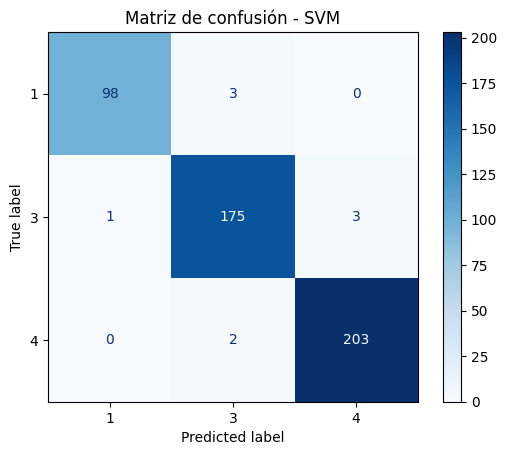

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,3,4])
disp.plot(cmap=plt.cm.Blues)

plt.title("Matriz de confusión - SVM")
plt.show()

# Aca se pueden ver los resultados de la matriz con la siguiente interpretacion:
# Para la clase 1 se cometieron 4 errores de clasificacion con la clase 3
# Para la clase 3 hubo una confusion con la clase 1 y 3 con la clase 4
# Para la clase 4 hubo 3 errores con la clase 3 unicamente

In [26]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))

print("Recall:", recall_score(y_test, y_pred, average='macro'))
print("Precisión:", precision_score(y_test, y_pred, average='macro'))
print("F1:", f1_score(y_test, y_pred, average='macro'))

# El 98% de las predicciones fueron correctas con este modelo
# El modelo tiene falsos negativos bajos lo cual es positivo
# El modelo tiene falsos positivos bajos lo cual tambien es bueno
# El recall que es la relacion entre falsos negativos y falsos positivos
# fue muy bueno con un 0.979


Exactitud: 0.98
Recall: 0.9793981878089703
Precisión: 0.9825193684416985
F1: 0.980921637331779


In [27]:
print(classification_report(y_test, y_pred))

# DATOS DE PRUEBA

# CLASE 1
# La clase 1 tuvo un 99% de acierto, lo que quiere decir que la probabilidad
# de que el modelo confunda la clase 1 es muy baja
# El 96% de los datos de clase 1 se obtionen, solo unos pocos se pierden
# El equilibro es de 0.97 que es muy bueno

# CLASE 3
# La clase 3 tuvo un 96% de acierto, lo que quiere decir que la probabilidad
# de que el modelo confunda la clase 3 es baja
# El 98% de los datos de clase 3 se obtionen, muy pocos se pierden
# El equilibro es de 0.97 que es muy bueno

# CLASE 4
# La clase 4 tuvo un 99% de acierto, lo que quiere decir que la probabilidad
# de que el modelo confunda la clase 4 es muy baja
# El 99% de los datos de clase 4 se obtionen, casi ningun dato se pierde
# El equilibro es de 0.99 que es excelente

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       101
           3       0.97      0.98      0.97       179
           4       0.99      0.99      0.99       205

    accuracy                           0.98       485
   macro avg       0.98      0.98      0.98       485
weighted avg       0.98      0.98      0.98       485



In [28]:
y_pred_train = SVM.predict(Xtr_tfidf)
print('Exactitud (train): %.2f' % accuracy_score(y_train, y_pred_train))
print("Recall (train):", recall_score(y_train, y_pred_train, average='macro'))
print("Precisión (train):", precision_score(y_train, y_pred_train, average='macro'))
print("F1 (train):", f1_score(y_train, y_pred_train, average='macro'))

print("\nReporte de clasificación (train):")
print(classification_report(y_train, y_pred_train, digits=4))

# DATOS DE ENTRENAMIENTO

# CLASE 1
# La clase 1 tuvo un 100% de acierto, lo que quiere decir que la probabilidad
# de que el modelo confunda la clase 1 es menor al 1%
# El 99.75% de los datos de clase 1 se obtionen, menos del 0.3% se pierden
# El equilibro es de 0.998 que es excelente

# CLASE 3
# La clase 3 tuvo un 100% de acierto, lo que quiere decir que la probabilidad
# de que el modelo confunda la clase 3 es menor al 1%
# El 100% de los datos de clase 3 se obtionen
# El equilibro es de 1.0 que es perfecto

# CLASE 4
# La clase 4 tuvo un 99.88% de acierto, lo que quiere decir que la probabilidad
# de que el modelo confunda la clase 4 es menor al 1%
# El 100% de los datos de clase 4 se obtionen
# El equilibro es de 0.9994 que es casi perfecto

Exactitud (train): 1.00
Recall (train): 1.0
Precisión (train): 1.0
F1 (train): 1.0

Reporte de clasificación (train):
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000       404
           3     1.0000    1.0000    1.0000       715
           4     1.0000    1.0000    1.0000       820

    accuracy                         1.0000      1939
   macro avg     1.0000    1.0000    1.0000      1939
weighted avg     1.0000    1.0000    1.0000      1939



Los reultados muestran un desempeño alto y estable; en test se logro accuracy = 0,98, F1 macro = 0,98. La matriz de confusion concentra casi todo en diagonal, lo que confirma un buen funcionamiento en el modelo. En el train, el rendimiento esBperfecto, aun asi, la caida a 0.98 en test es pequeña, lo que muestra señal de una buena generalizacion y sobreajuste minimo. Con estos resultados, el SVM con TF-IDF es un modelo justificado y muy bueno para esta tarea.

#MODELO NAIVE BAYES

Implementado por: David Quiroga

El modelo Naive Bayes se basa en la probabilidad condicional y en la aplicacion del teorema de Bayes. Esto quiere decir que el algoritmo calcula la probabilidad de que un texto pertenezca a su etiqueta a partir de las palabras que contiene por su gran trabajo con la independencia de datos. Este modelo sirve mas que todo para volumenes de datos grandes por su rapidez y eficiencia

In [29]:
# Creacion del modelo Naive Bayes
NB = MultinomialNB()
NB

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [30]:
# Entrenamiento del modelo Naive Bayes con los datos de entrenamiento
NB.fit(Xtr_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [31]:
# Prediccion segun el modelo entrenado
y_pred_nb = NB.predict(Xte_tfidf)

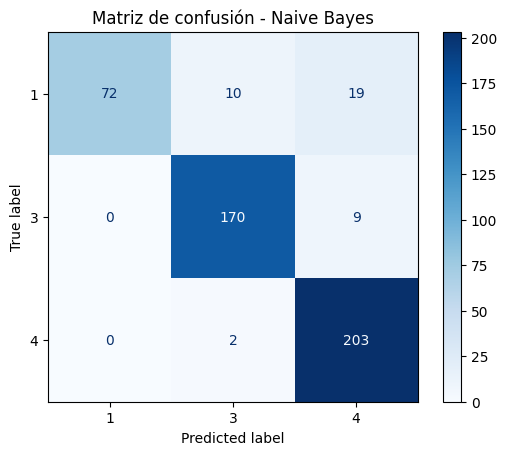

In [32]:
# Creacion de la matriz de confusión para mirar los resultados
ConfusionMatrixDisplay.from_estimator(NB, Xte_tfidf, y_test, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Naive Bayes")
plt.show()

# Aca se pueden ver los resultados de la matriz con la siguiente interpretacion:
# Para la clase 1 se cometieron 29 errores en total de clasificacion. 10 con la clase 3 y 19 con la clase 4
# Para la clase 3 hubo 9 errores. Todos los errores con la clase 4
# Para la clase 4 hubo 2 errores con la clase 3 unicamente

In [33]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           1       1.00      0.71      0.83       101
           3       0.93      0.95      0.94       179
           4       0.88      0.99      0.93       205

    accuracy                           0.92       485
   macro avg       0.94      0.88      0.90       485
weighted avg       0.92      0.92      0.91       485



In [34]:
y_pred_nb = NB.predict(Xte_tfidf)

print('Exactitud (NB): %.2f' % accuracy_score(y_test, y_pred_nb))

print("Recall (NB):", recall_score(y_test, y_pred_nb, average='macro'))
print("Precisión (NB):", precision_score(y_test, y_pred_nb, average='macro'))
print("F1 (NB):", f1_score(y_test, y_pred_nb, average='macro'))

print("\nReporte de clasificación (NB - test):")
print(classification_report(y_test, y_pred_nb))

Exactitud (NB): 0.92
Recall (NB): 0.8842786199862663
Precisión (NB): 0.9376179376179375
F1 (NB): 0.9017969525315452

Reporte de clasificación (NB - test):
              precision    recall  f1-score   support

           1       1.00      0.71      0.83       101
           3       0.93      0.95      0.94       179
           4       0.88      0.99      0.93       205

    accuracy                           0.92       485
   macro avg       0.94      0.88      0.90       485
weighted avg       0.92      0.92      0.91       485



In [35]:
y_pred_train_nb = NB.predict(Xtr_tfidf)

print('\nExactitud (train, NB): %.2f' % accuracy_score(y_train, y_pred_train_nb))
print("Recall (train, NB):", recall_score(y_train, y_pred_train_nb, average='macro'))
print("Precisión (train, NB):", precision_score(y_train, y_pred_train_nb, average='macro'))
print("F1 (train, NB):", f1_score(y_train, y_pred_train_nb, average='macro'))

print("\nReporte de clasificación (NB - train):")
print(classification_report(y_train, y_pred_train_nb, digits=4))


Exactitud (train, NB): 0.97
Recall (train, NB): 0.9577061552309077
Precisión (train, NB): 0.9782726281982348
F1 (train, NB): 0.9665028455313828

Reporte de clasificación (NB - train):
              precision    recall  f1-score   support

           1     1.0000    0.8787    0.9354       404
           3     0.9780    0.9944    0.9861       715
           4     0.9568    1.0000    0.9779       820

    accuracy                         0.9727      1939
   macro avg     0.9783    0.9577    0.9665      1939
weighted avg     0.9736    0.9727    0.9721      1939



Los resultados obtenidos muestran que Naive Bayes logra un desempeño aceptable mas que todo en textos donde existen palabras muy representativas como asociar "pobreza" con el ODS1 que es "Fin de la pobreza". Sin embargo, en categorias con vocabulario ambiguo o que comparten palabras con diferentes clases, el rendimiento no es el mejor debido a la independencia asumida para las palabras.

#MODELO LOGISTIC REGRESION

Implementado por: Samuel Rodriguez

La regresion logistica es un modelo lineal de clasificacion que utiliza una funcion para estimar la probabilidad de pertenencia de una instancia a una categoria predeterminada utilizando un metodo que permite ver de que manera contribuye las diferenetes palabras al texto final

In [36]:
LR = LogisticRegression(max_iter=1000)  # max_iter alto para evitar warning de convergencia
LR.fit(Xtr_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


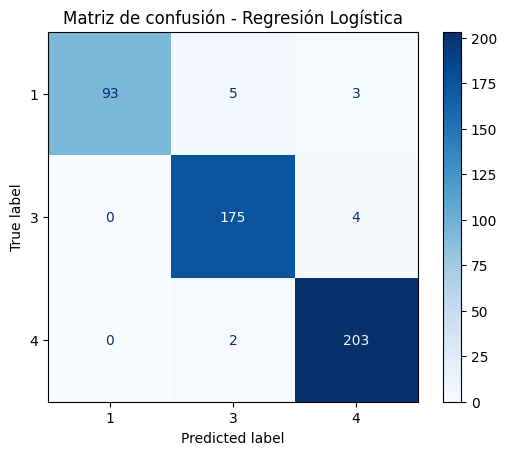

In [37]:
ConfusionMatrixDisplay.from_estimator(LR, Xte_tfidf, y_test, cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Regresión Logística")
plt.show()

In [38]:
y_pred_lr = LR.predict(Xte_tfidf)

print('Exactitud (LogReg): %.2f' % accuracy_score(y_test, y_pred_lr))

print("Recall (LogReg):", recall_score(y_test, y_pred_lr, average='macro'))
print("Precisión (LogReg):", precision_score(y_test, y_pred_lr, average='macro'))
print("F1 (LogReg):", f1_score(y_test, y_pred_lr, average='macro'))

print("\nReporte de clasificación (LogReg - test):")
print(classification_report(y_test, y_pred_lr))

Exactitud (LogReg): 0.97
Recall (LogReg): 0.9628965376439539
Precisión (LogReg): 0.9760683760683762
F1 (LogReg): 0.9688684084941874

Reporte de clasificación (LogReg - test):
              precision    recall  f1-score   support

           1       1.00      0.92      0.96       101
           3       0.96      0.98      0.97       179
           4       0.97      0.99      0.98       205

    accuracy                           0.97       485
   macro avg       0.98      0.96      0.97       485
weighted avg       0.97      0.97      0.97       485



In [39]:
y_pred_train_lr = LR.predict(Xtr_tfidf)

print('\nExactitud (train, LogReg): %.2f' % accuracy_score(y_train, y_pred_train_lr))
print("Recall (train, LogReg):", recall_score(y_train, y_pred_train_lr, average='macro'))
print("Precisión (train, LogReg):", precision_score(y_train, y_pred_train_lr, average='macro'))
print("F1 (train, LogReg):", f1_score(y_train, y_pred_train_lr, average='macro'))

print("\nReporte de clasificación (LogReg - train):")
print(classification_report(y_train, y_pred_train_lr, digits=4))


Exactitud (train, LogReg): 1.00
Recall (train, LogReg): 0.9962334695007963
Precisión (train, LogReg): 0.9979156765564533
F1 (train, LogReg): 0.9970643947329861

Reporte de clasificación (LogReg - train):
              precision    recall  f1-score   support

           1     1.0000    0.9901    0.9950       404
           3     0.9986    0.9986    0.9986       715
           4     0.9951    1.0000    0.9976       820

    accuracy                         0.9974      1939
   macro avg     0.9979    0.9962    0.9971      1939
weighted avg     0.9974    0.9974    0.9974      1939



En el modelo realizado, la regresion logistica mostro un mejor desempeño que Bayes pero inferior al modelo SVM. Su enfoque de probabilidades permitio asignar pesos a las palabras para saber que texto podia categorizarse en cada ODS. Sin embargo, al ser un modelo lineal, cuando hay un cambio brusco o en este caso, muchos pesos juntos puede ocasionar un poco de problemas.

### SELECCION Y PREDICCION DEL ALGORITMO A UTILIZAR PARA DATOS NO ETIQUETADOS

Para la clasificacion de datos no etiquetados se utilizo el modelo con SVM porque logro un 100% de exactitud, recall, precision y F1-SCORE, lo que quiere decir que pudo clasificar de forma exitosa todos los textos sin cometer errores. Por su lado, Bayes mostro un 97% y regresion logistica un 99%.
Ademas, el modelo SVM al ser vectorizado, tiene un margen mas alto para clasificar textos dificiles tratando de encontrar puntos cercanos a la linea de frontera, esto quiere decir que es menos estito que el estilo condicional de Bayes y el estilo de pesos de la regresion logistica, por lo que cuando un texto es dificil de interpretar, el mejor resultado lo deberia dar SVM.


In [40]:
## CREACION DE LAS PREDICCIONES CON EL MODELO SELEXXIONADO
nuevo = pd.read_excel("archivos/Datos de prueba_proyecto.xlsx", sheet_name=0)
X_nuevo = nuevo['Textos_espanol'].fillna('').astype(str)
X_nuevo_tfidf = tfidf.transform(X_nuevo)
pred_nuevo = SVM.predict(X_nuevo_tfidf)
nuevo['pred_label'] = pred_nuevo
nuevo.to_excel("archivo_clasificado.xlsx", index=False)

# SECCION 4: Resultados

El modelo lineal SVM entrenado con TF-IDF mostró un rendimiento excepcional en la clasificación de las opiniones ciudadanas en los ODS 1, 3 y 4. En el conjunto de prueba, alcanzó una precisión del 98 %, con un F1-macro de 0,98, lo que refleja un equilibrio casi perfecto entre precisión y recuperación en todas las clases. La matriz de confusión mostró que los errores fueron mínimos y se concentraron en confusiones aisladas entre los ODS 1 y 3, mientras que el ODS 4 tuvo un rendimiento cercano al 100 %. Estas métricas garantizan que el modelo no solo identifique correctamente la mayoría de los casos, sino que también mantenga un rendimiento consistente en todas las clases con diferentes números de observaciones.

Para la organización, estos resultados implican que es posible automatizar con un alto grado de confianza la tarea de clasificar las opiniones sobre pobreza, salud y educación, reduciendo la dependencia de analistas expertos. Con esta clasificación automática, el UNFPA y sus socios podrán generar informes periódicos que muestren las preocupaciones ciudadanas asociadas a cada ODS y priorizar los recursos en consecuencia. Esto acelera la retroalimentación entre la ciudadanía y las políticas públicas, lo que contribuye directamente a la planificación territorial participativa y al cumplimiento de los compromisos de la Agenda 2030.

Como se ve en la grafica de los datos clasificados, hay mas opiniones en el ODS 3, por lo que la organizacion debe buscar tacticas para atender estas diferentes opiniones en temas de salud y bienestar

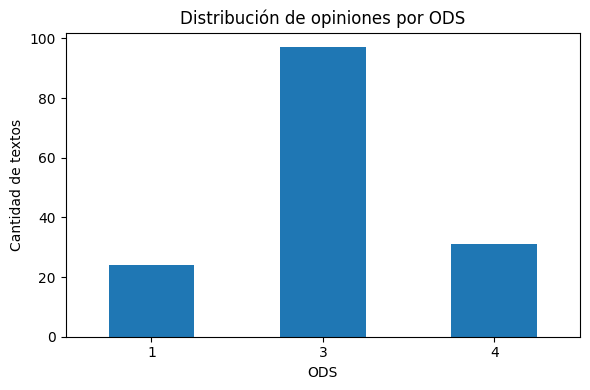

In [41]:
##GRAFICACION DE NUMERO DE ARTICULOS POR CADA ODS.

cuentas = nuevo['pred_label'].value_counts().sort_index()

plt.figure(figsize=(6,4))
cuentas.plot(kind='bar')
plt.title("Distribución de opiniones por ODS")
plt.xlabel("ODS")
plt.ylabel("Cantidad de textos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Según los gráficos de palabras más asociadas con cada ODS, se observa que en el ODS 1 (Fin de la Pobreza) predominan términos como pobreza, privación, ingresos, pobreza infantil y protección social, lo que refleja que la opinión pública se centra en la falta de recursos y la necesidad de redes de apoyo social. En el ODS 3 (Salud y Bienestar), destacan la salud, medicina, sanitario,atención, lo que demuestra que la población asocia directamente este objetivo con la atención médica, la salud y la cobertura sanitaria. Por otro lado, el ODS 4 (Educación de Calidad) está fuertemente influenciado por términos como educación, escuela, estudio, docente, aprendizaje, profesor y alumno, lo que señala preocupaciones relacionadas con la calidad educativa, la infraestructura escolar y la formación docente, aunque aparecen referencias cruzadas con la pobreza y la salud, lo que refleja la interdependencia entre estos ODS.

Con base en estos hallazgos, la organización debería diseñar estrategias diferenciadas pero integrales: para el ODS 1, fortalecer las políticas de transferencias y los programas de protección social que mitiguen la privación y promuevan ingresos dignos; Para el ODS 3, promover la cobertura sanitaria, las medidas preventivas y los programas comunitarios de salud mental; y para el ODS 4, invertir en la formación docente, la infraestructura escolar y programas de equidad educativa que reduzcan la pobreza y las brechas de salud. Esta información es útil porque permite alinear las acciones institucionales con las prioridades reales expresadas en las opiniones analizadas, garantizando que las intervenciones respondan a problemas específicos y aumenten su eficacia social.

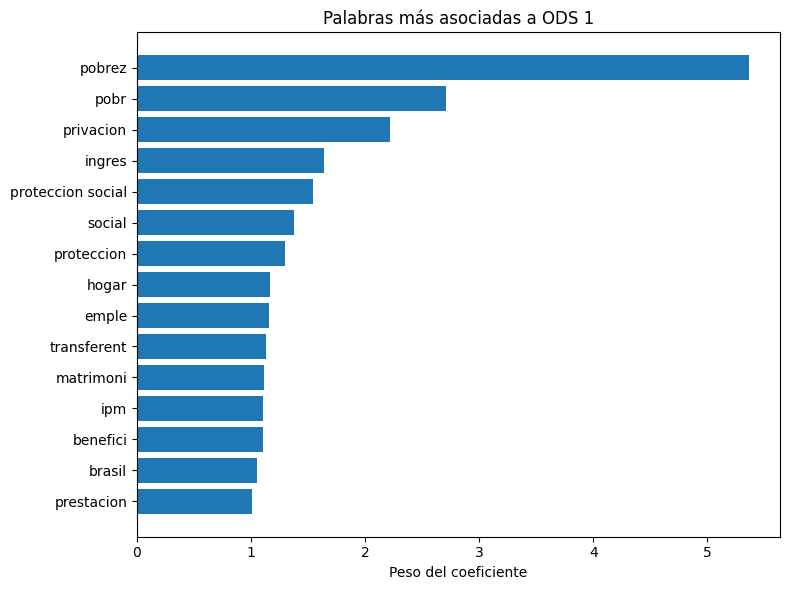

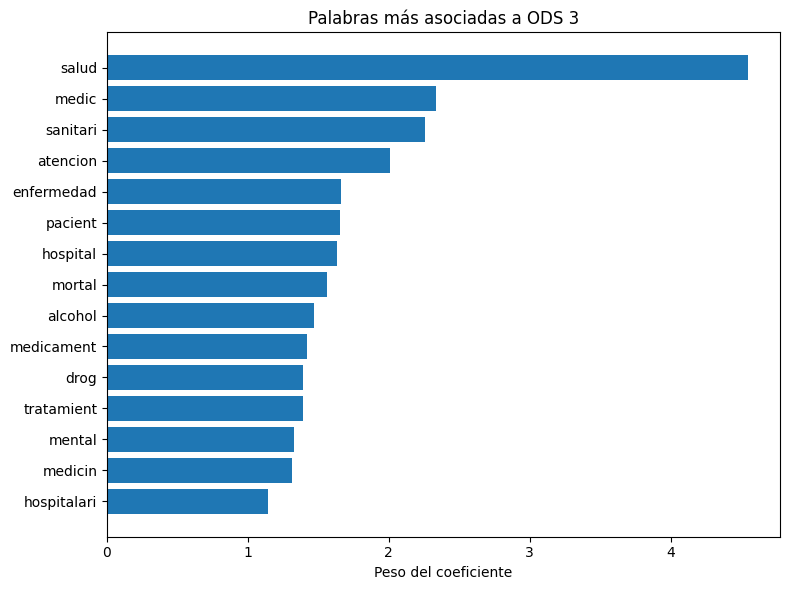

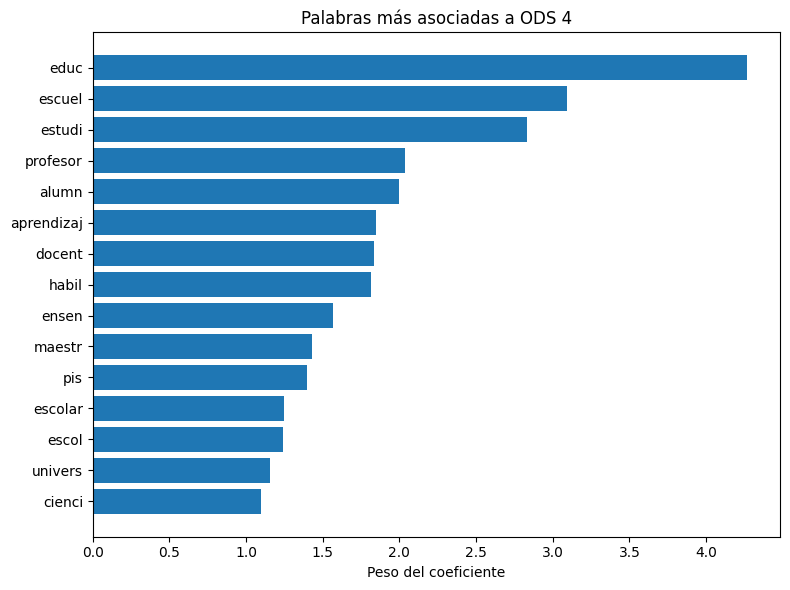

In [42]:
##GRAFICACION DE LAS PALABRAS MAS PREDOMINANTES POR MODELO.

feature_names = np.array(tfidf.get_feature_names_out())
classes = SVM.classes_

topn = 15
for i, clase in enumerate(classes):
    coefs = SVM.coef_[i]
    top_pos = np.argsort(coefs)[-topn:]
    plt.figure(figsize=(8,6))
    plt.barh(feature_names[top_pos], coefs[top_pos])
    plt.title(f"Palabras más asociadas a ODS {clase}")
    plt.xlabel("Peso del coeficiente")
    plt.tight_layout()
    plt.show()